In [1]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

from tqdm.notebook import tqdm

In [2]:
#os.chdir("C:/Users/USER/Desktop/LG")

# 1. cooktime of menus GESD

In [3]:
# time 변수 추가한 데이터 사용
df=pd.read_csv('Oven_sample.csv',encoding='cp949',parse_dates=['CREATE_DT','LOCAL_TIME','MONTH'],dayfirst=True)
df['time'] = df['Cook_hour'].astype(int)*60*60 + df['Cook_min'].astype(int)*60 + df['Cook_sec'].astype(int)
df

,CREATE_DT,LOCAL_TIME,DEVICE_ID,EVENT,Cook_State,Cook_Mode,Cook_menu,Cook_hour,Cook_min,Cook_sec,Target_temp,MONTH,time
0,2019-11-20 23:43:56,2019-11-21 08:43:56,id_00000,요리재시작,요리,오븐 자동,군고구마,0,28,38,0,2019-11-01,1718
1,2019-11-30 10:50:26,2019-11-30 19:50:26,id_00000,요리시작,요리,레인지,0,0,0,30,0,2019-11-01,30
2,2019-11-30 10:53:51,2019-11-30 19:53:51,id_00000,요리취소,대기,대기,0,0,0,0,0,2019-11-01,0
3,2019-11-30 10:50:45,2019-11-30 19:50:45,id_00000,요리멈춤,요리멈춤,레인지,0,0,2,42,0,2019-11-01,162
4,2019-11-30 10:53:49,2019-11-30 19:53:49,id_00000,요리멈춤,요리멈춤,레인지,0,0,0,31,0,2019-11-01,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
286392,2021-05-16 21:58:16,2021-05-17 06:58:16,id_00150,요리시작,요리,오븐,0,0,15,0,200,2021-05-01,900
286393,2021-05-09 05:06:40,2021-05-09 14:06:40,id_00150,요리시작,요리,레인지,0,0,0,30,0,2021-05-01,30
286394,2021-05-09 05:06:20,2021-05-09 14:06:20,id_00150,요리종료,요리종료,대기,0,0,0,0,0,2021-05-01,0
286395,2021-05-09 05:04:19,2021-05-09 14:04:19,id_00150,요리시작,요리,레인지,0,0,0,30,0,2021-05-01,30


In [4]:
df=df[['CREATE_DT','DEVICE_ID','EVENT','Cook_State','Cook_Mode','Cook_menu','Target_temp','time']]

## 1-1. GESD 함수 정의

In [6]:
def grubbs_stat(y):
    std_dev = np.std(y)
    avg_y = np.mean(y)
    abs_val_minus_avg = abs(y - avg_y)
    max_of_deviations = max(abs_val_minus_avg)
    max_ind = np.argmax(abs_val_minus_avg)
    Gcal = max_of_deviations/ std_dev
    print("Grubbs Statistics Value : {}".format(Gcal))
    return Gcal, max_ind

In [7]:
def calculate_critical_value(size, alpha):
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
    print("Grubbs Critical Value: {}".format(critical_value))
    return critical_value

In [8]:
def check_G_values(Gs, Gc, inp, max_index):
    if Gs > Gc:
        print('{} is an outlier. G > G-critical: {:.4f} > {:.4f} \n'.format(inp[max_index], Gs, Gc))
    else:
        print('{} is not an outlier. G > G-critical: {:.4f} > {:.4f} \n'.format(inp[max_index], Gs, Gc))

In [9]:
def ESD_Test(input_series, alpha, max_outliers):
    for iterations in range(max_outliers):
        Gcritical = calculate_critical_value(len(input_series), alpha)
        Gstat, max_index = grubbs_stat(input_series)
        check_G_values(Gstat, Gcritical, input_series, max_index)
        input_series = np.delete(input_series, max_index)

In [10]:
np.unique(df['Cook_menu'])

array(['0', 'My_Recipe', '가래떡구이', '가리비치즈구이', '가자미', '가자미오븐구이', '가지',
       '갈비구이', '갈치구이', '감', '감건조', '감자그라탱', '감자삶기', '고구마맛탕', '고구마칩&감자칩',
       '고등어구이', '구운달걀', '국데우기', '군고구마', '깻잎', '꽁치구이', '꽈리고추', '냉동감자',
       '냉동군만두', '냉동너겟', '냉동돈가스', '냉동밥데우기', '냉동생선가스', '냉동조기구이', '냉동크로켓',
       '냉동피자', '냉동핫도그', '냉장밥데우기', '너비아니구이', '누룽지', '누룽지튀김', '단호박수프',
       '단호박영양밥', '단호박찜', '달걀찜', '닭가슴살', '닭강정', '닭꼬치', '닭다리', '대게', '도미',
       '동원_퀴진체바피소시지', '두부강정', '두부데우기', '떡데우기(멥쌀)', '떡데우기(찹쌀)', '또띠아피자',
       '라면', '라이스핫도그', '라자냐', '롤케이크', '리소토', '립바비큐', '마늘빵', '만두탕수',
       '모듬야채구이', '무', '무건조', '민어조기', '바나나', '바나나건조', '백설기', '베이글', '병어',
       '브라우니', '브로콜리', '빵반죽', '사과호두머핀', '삼겹살', '삼치구이', '새우', '새우구이',
       '새우튀김', '생선', '섭산적', '솎음배추', '수제돈가스', '스콘', '스테이크', '스팀발생기세정',
       '스팀청소', '스폰지케이크', '식빵', '아코디언감자구이', '어니언링', '연어스테이크', '오븐스파게티',
       '오징어', '오징어건조', '오징어링', '오코노미야끼', '옥수수', '요구르트', '요리취소', '우유데우기',
       '웨지감자', '육포', '인절미', '일식달걀찜', '잔수제거', '장어양념구이', '전통수육', '조기',
       '조

## 1-2. preprocessing

In [11]:
#요리 메뉴 전처리
df=df[~df['Cook_menu'].isin(['0','My_Recipe','스팀청소','스팀발생기세정','요리취소','잔수제거','조리실건조','탈취','해동'])].reset_index(drop=True)
df

,CREATE_DT,DEVICE_ID,EVENT,Cook_State,Cook_Mode,Cook_menu,Target_temp,time
0,2019-11-20 23:43:56,id_00000,요리재시작,요리,오븐 자동,군고구마,0,1718
1,2019-11-29 15:40:11,id_00000,요리멈춤,요리멈춤,오븐 자동,군고구마,0,271
2,2019-11-29 15:13:12,id_00000,요리시작,요리,오븐 자동,군고구마,0,1890
3,2019-11-20 23:26:07,id_00000,요리시작,요리,오븐 자동,군고구마,0,2040
4,2019-11-20 23:37:36,id_00000,요리시작,요리,오븐 자동,군고구마,0,2040
...,...,...,...,...,...,...,...,...
24899,2021-03-29 11:08:34,id_00150,요리시작,요리,구이 자동,삼치구이,0,1080
24900,2021-04-19 10:46:48,id_00150,요리시작,요리,최근사용메뉴,갈치구이,0,900
24901,2021-04-19 10:56:06,id_00150,요리멈춤,요리멈춤,최근사용메뉴,갈치구이,0,345
24902,2021-04-19 10:54:12,id_00150,요리멈춤,요리멈춤,최근사용메뉴,갈치구이,0,457


In [12]:
df['Cook_menu'].value_counts()[:70]

식빵          3636
군고구마        2672
냉동밥데우기      1523
냉동돈가스       1109
냉동피자         905
            ... 
새우구이          53
황태양념구이        52
육포            49
통감자           47
떡데우기(멥쌀)      46
Name: Cook_menu, Length: 70, dtype: int64

In [13]:
#요리재시작, 요리시작인 경우 전처리
df=df[df['EVENT'].isin(['요리재시작','요리시작'])].reset_index(drop=True)
df

,CREATE_DT,DEVICE_ID,EVENT,Cook_State,Cook_Mode,Cook_menu,Target_temp,time
0,2019-11-20 23:43:56,id_00000,요리재시작,요리,오븐 자동,군고구마,0,1718
1,2019-11-29 15:13:12,id_00000,요리시작,요리,오븐 자동,군고구마,0,1890
2,2019-11-20 23:26:07,id_00000,요리시작,요리,오븐 자동,군고구마,0,2040
3,2019-11-20 23:37:36,id_00000,요리시작,요리,오븐 자동,군고구마,0,2040
4,2019-11-27 11:14:52,id_00000,요리재시작,요리,오븐 자동,군고구마,0,844
...,...,...,...,...,...,...,...,...
17066,2021-02-28 09:49:03,id_00150,요리시작,요리,오븐 자동,초코칩쿠키,0,1200
17067,2021-03-19 11:39:26,id_00150,요리시작,요리,구이 자동,고등어구이,0,930
17068,2021-03-29 11:08:34,id_00150,요리시작,요리,구이 자동,삼치구이,0,1080
17069,2021-04-19 10:46:48,id_00150,요리시작,요리,최근사용메뉴,갈치구이,0,900


## 1-3. 사용 수가 중위권인 메뉴 GESD & histogram

### 장어양넘구이

In [14]:
df1=df[df['Cook_menu']=="장어양념구이"].reset_index(drop=True)
y=df1['time']
ESD_Test(np.array(y),0.05,5)

Grubbs Critical Value: 3.1932139689801295
Grubbs Statistics Value : 1.8140425190410927
9 is not an outlier. G > G-critical: 1.8140 > 3.1932 

Grubbs Critical Value: 3.1866284591724883
Grubbs Statistics Value : 1.7449590416645813
42 is not an outlier. G > G-critical: 1.7450 > 3.1866 

Grubbs Critical Value: 3.179899755889007
Grubbs Statistics Value : 1.7791683076832119
49 is not an outlier. G > G-critical: 1.7792 > 3.1799 

Grubbs Critical Value: 3.1730219854111694
Grubbs Statistics Value : 1.8392206192482923
51 is not an outlier. G > G-critical: 1.8392 > 3.1730 

Grubbs Critical Value: 3.165988918336084
Grubbs Statistics Value : 1.7142770248522239
96 is not an outlier. G > G-critical: 1.7143 > 3.1660 



(array([ 4.,  6.,  5.,  7.,  2.,  4.,  9.,  7.,  2., 13.]),
 array([  9. ,  86.1, 163.2, 240.3, 317.4, 394.5, 471.6, 548.7, 625.8,
        702.9, 780. ]),
 <a list of 10 Patch objects>)

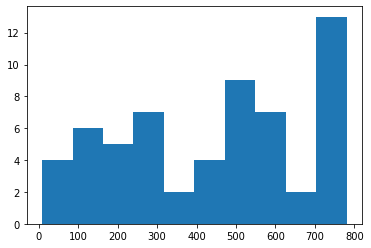

In [15]:
plt.hist(y)

### 닭가슴살

In [16]:
df2=df[df['Cook_menu']=="닭가슴살"].reset_index(drop=True)
y=df2['time']
ESD_Test(np.array(y),0.05,5)

Grubbs Critical Value: 3.476210073829718
Grubbs Statistics Value : 1.9298274034441065
61 is not an outlier. G > G-critical: 1.9298 > 3.4762 

Grubbs Critical Value: 3.4737523569490607
Grubbs Statistics Value : 1.782746919017881
122 is not an outlier. G > G-critical: 1.7827 > 3.4738 

Grubbs Critical Value: 3.471272236777101
Grubbs Statistics Value : 1.799801017203844
126 is not an outlier. G > G-critical: 1.7998 > 3.4713 

Grubbs Critical Value: 3.4687693246343625
Grubbs Statistics Value : 1.82074801786268
129 is not an outlier. G > G-critical: 1.8207 > 3.4688 

Grubbs Critical Value: 3.466243221912549
Grubbs Statistics Value : 1.62438734462337
1260 is not an outlier. G > G-critical: 1.6244 > 3.4662 



(array([ 4., 14., 18., 14.,  6., 26., 17.,  9.,  5., 19.]),
 array([  61. ,  180.9,  300.8,  420.7,  540.6,  660.5,  780.4,  900.3,
        1020.2, 1140.1, 1260. ]),
 <a list of 10 Patch objects>)

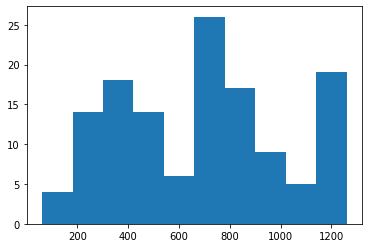

In [17]:
plt.hist(y)

### 육포

In [18]:
df3=df[df['Cook_menu']=="육포"].reset_index(drop=True)
y=df3['time']
ESD_Test(np.array(y),0.05,5)

Grubbs Critical Value: 2.908473059722726
Grubbs Statistics Value : 1.884764947965816
1987 is not an outlier. G > G-critical: 1.8848 > 2.9085 

Grubbs Critical Value: 2.8927047112054254
Grubbs Statistics Value : 2.0196243308558057
2229 is not an outlier. G > G-critical: 2.0196 > 2.8927 

Grubbs Critical Value: 2.8762091343069227
Grubbs Statistics Value : 1.7595331010331918
6173 is not an outlier. G > G-critical: 1.7595 > 2.8762 

Grubbs Critical Value: 2.85892285133109
Grubbs Statistics Value : 1.7575436691921507
7368 is not an outlier. G > G-critical: 1.7575 > 2.8589 

Grubbs Critical Value: 2.8407740764172646
Grubbs Statistics Value : 1.7004480134433486
8984 is not an outlier. G > G-critical: 1.7004 > 2.8408 



(array([ 2.,  1.,  2.,  2.,  8.,  0.,  0.,  0.,  0., 15.]),
 array([ 1987. ,  4668.3,  7349.6, 10030.9, 12712.2, 15393.5, 18074.8,
        20756.1, 23437.4, 26118.7, 28800. ]),
 <a list of 10 Patch objects>)

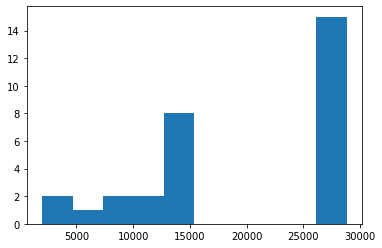

In [19]:
plt.hist(y)

## 1-4. 사용 수가 상위권인 메뉴 GESD & histogram

### 군고구마

In [20]:
df1=df[df['Cook_menu']=='군고구마'].reset_index(drop=True)
y=df1['time']

ESD_Test(np.array(y),0.05,5)

Grubbs Critical Value: 4.201736631799477
Grubbs Statistics Value : 3.2991322929749023
3118 is not an outlier. G > G-critical: 3.2991 > 4.2017 

Grubbs Critical Value: 4.201617784429733
Grubbs Statistics Value : 3.2915829139068666
18 is not an outlier. G > G-critical: 3.2916 > 4.2016 

Grubbs Critical Value: 4.201498872068891
Grubbs Statistics Value : 3.2866077185805045
25 is not an outlier. G > G-critical: 3.2866 > 4.2015 

Grubbs Critical Value: 4.201379894647752
Grubbs Statistics Value : 3.2387576004542957
52 is not an outlier. G > G-critical: 3.2388 > 4.2014 

Grubbs Critical Value: 4.201260852093461
Grubbs Statistics Value : 3.233271139542951
59 is not an outlier. G > G-critical: 3.2333 > 4.2013 



(array([ 79.,  81.,  57.,  58., 511., 523., 650.,   1.,   2.,   2.]),
 array([  18.,  328.,  638.,  948., 1258., 1568., 1878., 2188., 2498.,
        2808., 3118.]),
 <a list of 10 Patch objects>)

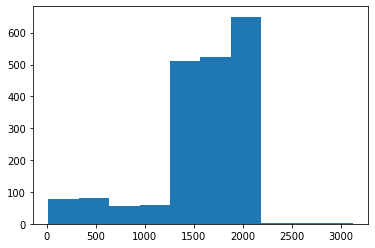

In [21]:
plt.hist(y)

### 식빵

In [22]:
df2=df[df['Cook_menu']=='식빵'].reset_index(drop=True)
y2=df2['time']

ESD_Test(np.array(y2),0.05,5)

Grubbs Critical Value: 4.237172945856669
Grubbs Statistics Value : 2.8315198621038924
495 is not an outlier. G > G-critical: 2.8315 > 4.2372 

Grubbs Critical Value: 4.23707204097784
Grubbs Statistics Value : 1.586767243327724
1 is not an outlier. G > G-critical: 1.5868 > 4.2371 

Grubbs Critical Value: 4.236971088875139
Grubbs Statistics Value : 1.5879890242015093
1 is not an outlier. G > G-critical: 1.5880 > 4.2370 

Grubbs Critical Value: 4.236870089510913
Grubbs Statistics Value : 1.5802524388020116
2 is not an outlier. G > G-critical: 1.5803 > 4.2369 

Grubbs Critical Value: 4.236769042838593
Grubbs Statistics Value : 1.5366424508717238
7 is not an outlier. G > G-critical: 1.5366 > 4.2368 



(array([675., 203.,  56., 136., 130., 852., 235.,   0.,   0.,   1.]),
 array([  1. ,  50.4,  99.8, 149.2, 198.6, 248. , 297.4, 346.8, 396.2,
        445.6, 495. ]),
 <a list of 10 Patch objects>)

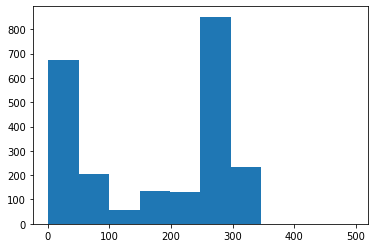

In [23]:
plt.hist(y2)

### 냉동밥데우기

In [24]:
df3=df[df['Cook_menu']=='냉동밥데우기'].reset_index(drop=True)
y3=df3['time']

ESD_Test(np.array(y3),0.05,5)

Grubbs Critical Value: 4.11424144338545
Grubbs Statistics Value : 2.740257878513852
367 is not an outlier. G > G-critical: 2.7403 > 4.1142 

Grubbs Critical Value: 4.114064415764929
Grubbs Statistics Value : 2.6313096628593713
6 is not an outlier. G > G-critical: 2.6313 > 4.1141 

Grubbs Critical Value: 4.1138872468281535
Grubbs Statistics Value : 2.639031554978465
6 is not an outlier. G > G-critical: 2.6390 > 4.1139 

Grubbs Critical Value: 4.11370993635427
Grubbs Statistics Value : 2.6019137854468197
9 is not an outlier. G > G-critical: 2.6019 > 4.1137 

Grubbs Critical Value: 4.113532484124912
Grubbs Statistics Value : 2.5644074441836096
12 is not an outlier. G > G-critical: 2.5644 > 4.1135 



(array([ 15.,  15.,   7., 994.,   3.,   4.,   0.,   2., 316.,   1.]),
 array([  6. ,  42.1,  78.2, 114.3, 150.4, 186.5, 222.6, 258.7, 294.8,
        330.9, 367. ]),
 <a list of 10 Patch objects>)

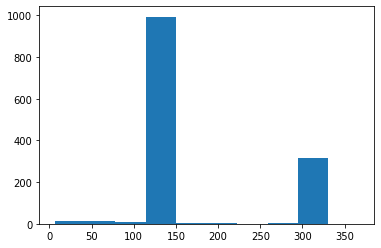

In [25]:
plt.hist(y3)

### 냉장밥데우기

In [26]:
df4=df[df['Cook_menu']=='냉장밥데우기'].reset_index(drop=True)
y4=df4['time']

ESD_Test(np.array(y4),0.05,5)

Grubbs Critical Value: 3.989063039711982
Grubbs Statistics Value : 2.599709982121489
200 is not an outlier. G > G-critical: 2.5997 > 3.9891 

Grubbs Critical Value: 3.9887544650971036
Grubbs Statistics Value : 2.612173164910076
200 is not an outlier. G > G-critical: 2.6122 > 3.9888 

Grubbs Critical Value: 3.9884454742249815
Grubbs Statistics Value : 2.624817331682072
200 is not an outlier. G > G-critical: 2.6248 > 3.9884 

Grubbs Critical Value: 3.9881360660060388
Grubbs Statistics Value : 2.6376469055367378
200 is not an outlier. G > G-critical: 2.6376 > 3.9881 

Grubbs Critical Value: 3.987826239345804
Grubbs Statistics Value : 2.650666462403616
200 is not an outlier. G > G-critical: 2.6507 > 3.9878 



(array([  2.,   4.,   3., 601.,   1.,   1., 130.,   0.,   0.,  73.]),
 array([ 16. ,  34.4,  52.8,  71.2,  89.6, 108. , 126.4, 144.8, 163.2,
        181.6, 200. ]),
 <a list of 10 Patch objects>)

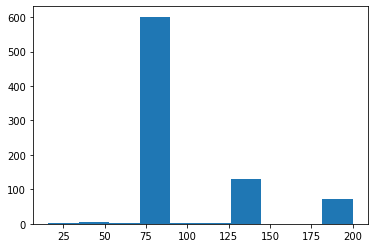

In [27]:
plt.hist(y4)

메뉴별로 파악해봤을때 요리 시간에서 이상치가 나타나는 경우는 찾지 못함